In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("darkgrid")

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import RobustScaler

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [3]:
train = pd.read_csv("/kaggle/input/mvp-subset/trainmod.csv", index_col=[0])
test = pd.read_csv("/kaggle/input/mvp-subset/testmod.csv", index_col=[0])

In [4]:
train.shape

(4828800, 6)

In [5]:
print(train.columns)

Index(['R', 'C', 'time_step', 'u_in', 'u_out', 'pressure'], dtype='object')


In [6]:
feature_cols = ["R","C", "u_in", "u_out"]

In [7]:
n_steps = 80
n_features = len(feature_cols)
target_column_name = 'pressure'  # Replace with the actual target column name

# Assuming "train" is a DataFrame containing your training data
n_samples_train = len(train) // n_steps  # Calculate the number of breaths
y_train = train[target_column_name].values[:n_samples_train * n_steps].reshape(-1, n_steps)
X_train = train[feature_cols].values[:n_samples_train * n_steps].reshape(-1, n_steps, n_features)

print(X_train.shape, y_train.shape)

(60360, 80, 4) (60360, 80)


In [8]:
def get_model():
    act = 'gelu'  # Use the mish activation function
    model = tf.keras.Sequential([
        layers.InputLayer(input_shape=(n_steps, n_features)),
        layers.Bidirectional(layers.LSTM(150, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(150, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(150, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(150, return_sequences=True)),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(256, activation=act),  # Added a Dense layer
        layers.Dense(512, activation=act),  # Added another Dense layer
        layers.Dense(256, activation=act),  # Added one more Dense layer
        layers.Dense(128, activation=act),  # Added another Dense layer
        layers.Dense(80)
    ])
    return model

# Create the model within a strategy scope (if using distributed training)
with strategy.scope():
    model = get_model()
    model.compile(optimizer="adam", loss="mae")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 80, 300)          186000    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 80, 300)          541200    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 80, 300)          541200    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 80, 300)          541200    
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 80, 300)           0

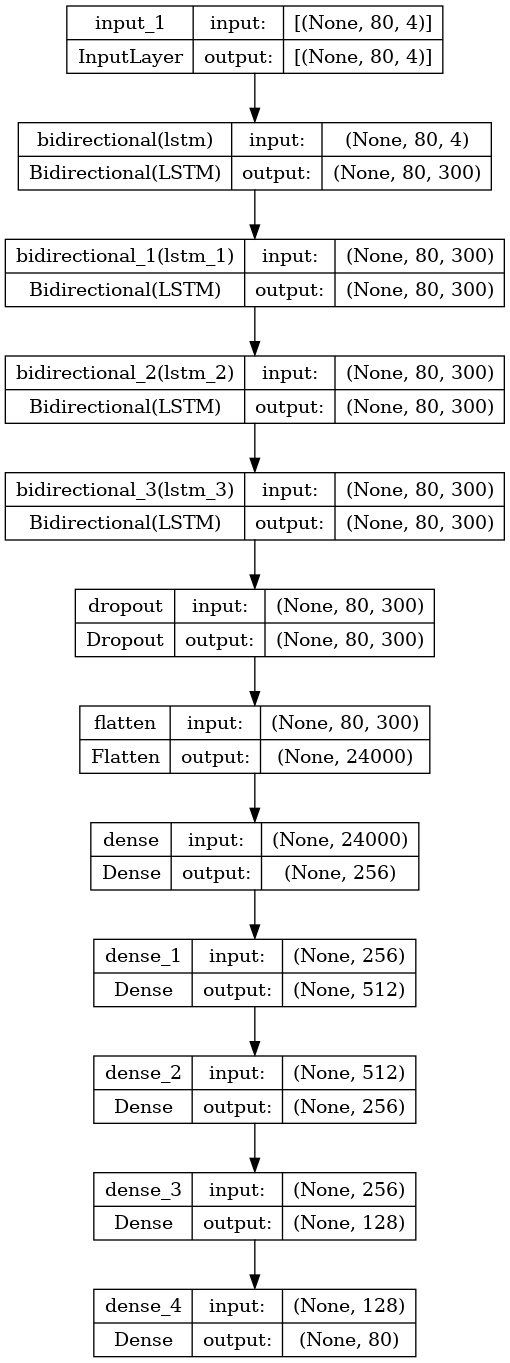

In [9]:
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [10]:
# Define a learning rate scheduler
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4, decay_steps=1e4, decay_rate=1e-5)

# Define callbacks for early stopping and learning rate scheduling
cb_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
cb_es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=512, callbacks=[cb_es, cb_lr])

Epoch 1/200
95/95 [==============================] - 45s 256ms/step - loss: 5.5842 - val_loss: 2.1888 - lr: 1.0000e-04
Epoch 2/200
95/95 [==============================] - 22s 231ms/step - loss: 1.7419 - val_loss: 1.4679 - lr: 9.9885e-05
Epoch 3/200
95/95 [==============================] - 23s 239ms/step - loss: 1.3705 - val_loss: 1.2685 - lr: 9.9770e-05
Epoch 4/200
95/95 [==============================] - 23s 242ms/step - loss: 1.2001 - val_loss: 1.1335 - lr: 9.9655e-05
Epoch 5/200
95/95 [==============================] - 24s 248ms/step - loss: 1.1155 - val_loss: 1.0805 - lr: 9.9541e-05
Epoch 6/200
95/95 [==============================] - 25s 260ms/step - loss: 1.0583 - val_loss: 1.0113 - lr: 9.9426e-05
Epoch 7/200
95/95 [==============================] - 24s 258ms/step - loss: 1.0217 - val_loss: 0.9862 - lr: 9.9312e-05
Epoch 8/200
95/95 [==============================] - 24s 252ms/step - loss: 1.0005 - val_loss: 0.9564 - lr: 9.9197e-05
Epoch 9/200
95/95 [=============================

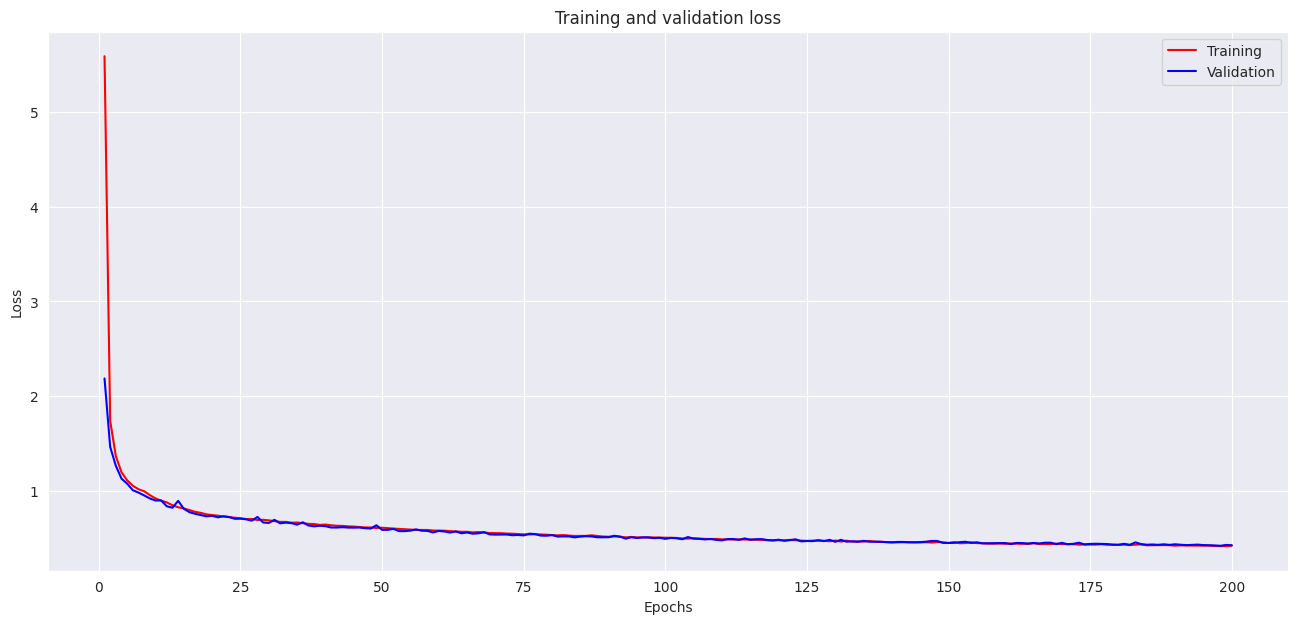

In [11]:
plt.figure(figsize=(16,7))
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1,len(loss)+1)

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.legend(["Training", "Validation" ])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and validation loss')

plt.show()

In [12]:
train = pd.read_csv("/kaggle/input/mvp-subset/trainmod.csv")

1/1 [==============================] - 3s 3s/step


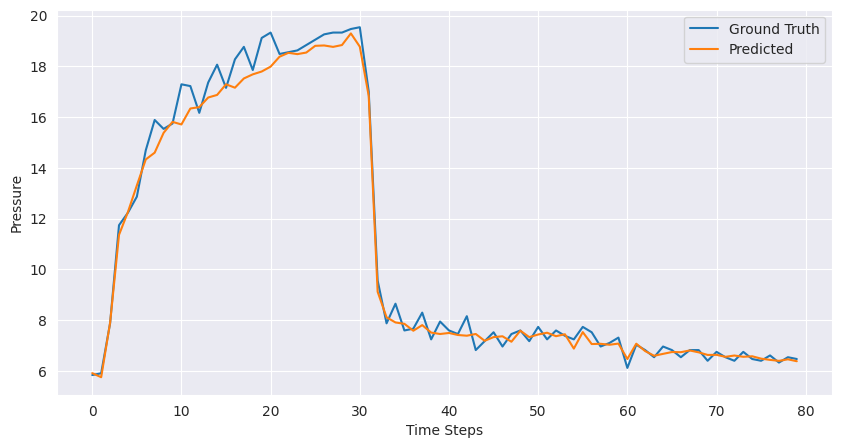

In [13]:
idx = 1
df_plot = train[train['breath_id'] == idx]
p = model.predict(df_plot[feature_cols].values.reshape(-1, n_steps, n_features))
x = range(len(df_plot))  # Use the length of df_plot for x values
y = df_plot['pressure']
plt.figure(figsize=(10, 5))
sns.lineplot(x=x, y=y, label="Ground Truth")
sns.lineplot(x=x, y=p.reshape(-1), label="Predicted")
plt.legend()
plt.ylabel("Pressure")
plt.xlabel("Time Steps")
plt.show()

In [14]:
test = pd.read_csv("/kaggle/input/mvp-subset/testmod.csv")

In [15]:
feature_cols = ["R","C", "u_in", "u_out"]
n_steps = 80
n_features = len(feature_cols)
target_column_name = 'pressure'  # Replace with the actual target column name

# Assuming "train" is a DataFrame containing your training data
n_samples_test = len(test) // n_steps  # Calculate the number of breaths
y_test = test[target_column_name].values[:n_samples_test * n_steps].reshape(-1, n_steps)
X_test = test[feature_cols].values[:n_samples_test * n_steps].reshape(-1, n_steps, n_features)

print(X_test.shape, y_test.shape)

(15090, 80, 4) (15090, 80)


In [16]:
from sklearn.metrics import mean_absolute_error

1/1 [==============================] - 3s 3s/step
Mean Absolute Error (MAE): 0.41706445161682837


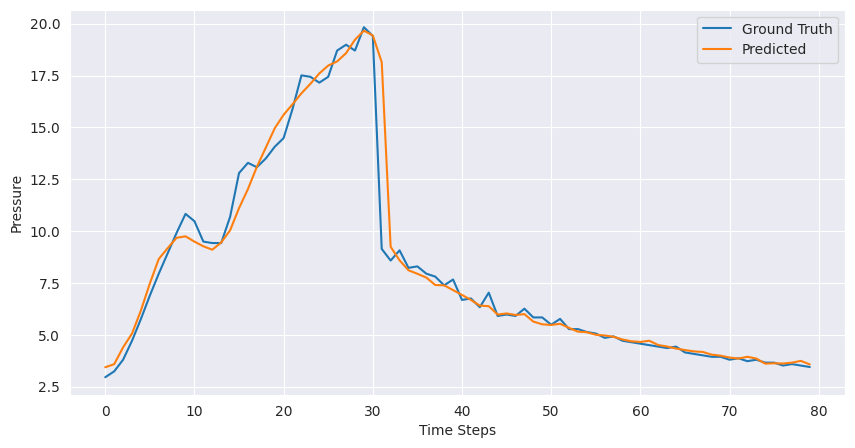

In [17]:
idx = 100616
df_plot = test[test['breath_id'] == idx]  # Use the test data

# Check if df_plot is empty
if df_plot.empty:
    print("No data found for the specified breath_id.")
else:
    # Assuming your model expects input shape (batch_size, n_steps, n_features)
    n_steps = 80  # Adjust this according to your model's input shape
    n_features = 4  # Adjust this according to your model's input shape
    feature_cols = ['R', 'C', 'u_in', 'u_out']  # Adjust these columns

    # Check if the columns exist in df_plot
    if all(col in df_plot.columns for col in feature_cols):
        input_data = df_plot[feature_cols].values.reshape(1, n_steps, n_features)  # Reshape for prediction

        # Make sure your model is compiled before predicting
        model.compile(optimizer='adam', loss='mae')  # Adjust optimizer and loss

        p = model.predict(input_data)
        x = range(len(df_plot))  # Use the length of df_plot for x values
        y = df_plot['pressure']

        # Calculate MAE
        mae = mean_absolute_error(y, p[0])

        print(f"Mean Absolute Error (MAE): {mae}")

        # Plot the results
        plt.figure(figsize=(10, 5))
        sns.lineplot(x=x, y=y, label="Ground Truth")
        sns.lineplot(x=x, y=p[0], label="Predicted")  # p[0] because there's only one prediction
        plt.legend()
        plt.ylabel("Pressure")
        plt.xlabel("Time Steps")
        plt.show()
    else:
        print("Some feature columns are missing in the DataFrame.")

In [18]:
model.save('our_model_gelu_more_layers.keras')

In [19]:
loaded_model_keras = tf.keras.models.load_model('our_model_gelu_more_layers.keras')